<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARIMA-14.09.2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [184]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

stock = "vrtx"

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14")

df_close = stock_data['Close']
df_log = np.log(df_close)
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

best_order = model_autoARIMA.order
print("Best ARIMA Order:", best_order)

[*********************100%%**********************]  1 of 1 completed
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23177.246, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=2.88 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16966.310, Time=4.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-16965.724, Time=4.63 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12514.946, Time=1.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.37 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=5.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16968.733, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3686.985, Time=2.92 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-16964.749, Time=2.98 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-16968.2

In [185]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

start="2023-09-01"
end="2023-09-11"

stock_data = yf.download(stock, start=start, end=end, progress=False)
new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)
model = ARIMA(np.log(stock_data["Close"]), order=best_order)
fitted = model.fit()

print(len(stock_data))

5


FİYAT:  351.81 TL

ÜST PROJEKSİYON:  352.49 TL
ALT PROJEKSİYON:  338.72 TL



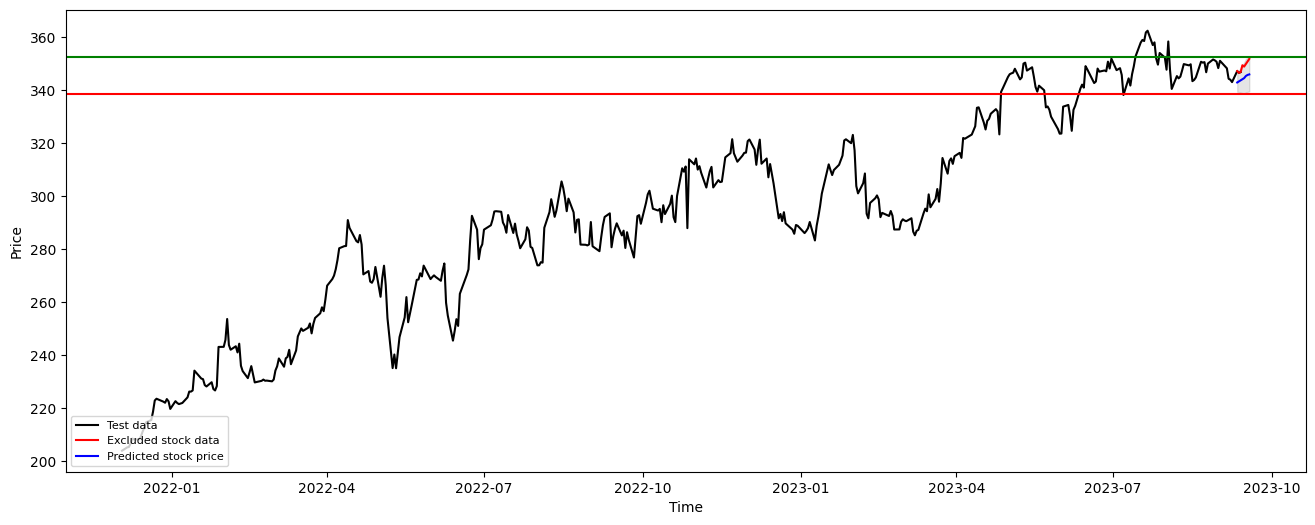

In [186]:
forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=stock_data.index)
lower_series = pd.DataFrame([new_date_index,conf.iloc[:, 0]]).T

plt.figure(figsize=(16,6), dpi=100)
plt.plot(np.exp(test_data), color='black', label='Test data')

import datetime
def get_last_weekday_date():
    today = datetime.date.today()
    while today.weekday() >= 5:
        today -= datetime.timedelta(days=1)
    return today
last_weekday_date = get_last_weekday_date()
last_weekday_date = last_weekday_date.strftime("%Y-%m-%d")
tomorrow = pd.Timestamp(last_weekday_date)
tomorrow+=datetime.timedelta(days=1)
tomorrow = tomorrow.strftime("%Y-%m-%d")

stock_data = yf.download(stock, start=end, end=tomorrow, progress=False)
plt.plot(stock_data.index, stock_data["Close"], color='red', label='Excluded stock data')

plt.plot(new_date_index, np.exp(fc), color='blue', label='Predicted stock price')  # Convert back to original scale
plt.fill_between(new_date_index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

print("FİYAT: ", round(stock_data["Close"].iloc[-1], 2), "TL\n")
print("ÜST PROJEKSİYON: ", round(np.exp(conf.iloc[:, 1].max()), 2), "TL")
print("ALT PROJEKSİYON: ", round(np.exp(conf.iloc[:, 0].min()), 2), "TL\n")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

In [ ]:
model = ARIMA(train_data, order=best_order)
fitted = model.fit()

forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(16,6), dpi=100)
plt.plot(np.exp(train_data[1000:]), label='Training data', color="black")
plt.plot(np.exp(test_data), color='blue', label='Test data')

plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)


plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.09320256713184302
MAE: 0.273399075797982
RMSE: 0.3052909548804927
MAPE: 0.026874539387259498


In [ ]:
;import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

market = []

url = f"https://tr.tradingview.com/symbols/NASDAQ-NDX/components/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all(class_="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat")

  for element in elements:
    text = element.get_text()
    market.append(text)

# nasdaq100 = ['MARA', 'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN',
#              'NVDA', 'TSLA', 'META', 'AVGO', 'ASML',
#              'PEP', 'COST', 'ADBE', 'AZN', 'CSCO',
#              'NFLX', 'AMD', 'CMCSA', 'TMUS', 'TXN',
#              'QCOM', 'HON', 'INTU', 'INTC', 'SNY',
#              'VZ', 'AMGN', 'SBUX', 'ISRG', 'AMAT',
#              'BKNG', 'ADI', 'MDLZ', 'PDD', 'GILD',
#              'ADP', 'VRTX', 'ABNB', 'LRCX', 'PYPL',
#              'REGN', 'EQIX', 'MU', 'CSX', 'SNPS',
#              'CME', 'CDNS', 'KLAC', 'NTES']

# sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
# sheet_name = "Sheet_1"
# url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# result_df = pd.read_csv(url)

bist_best_orders = pd.DataFrame()

for stock in market:
  try:
    print(stock)
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
    stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14", progress=False)

    df_close = stock_data['Close']
    df_log = np.log(df_close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

    best_order = model_autoARIMA.order
    bist_best_orders = pd.concat([bist_best_orders, pd.DataFrame([[stock, best_order]], columns=["STOCK", "BEST ORDER"])])

  except:
    pass

bist_best_orders.to_excel("NASDAQ_ORDERS.xls")

In [183]:
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
import ast

order_df = pd.read_excel("NASDAQ_ORDERS.xls")

for stock in order_df["STOCK"].unique():
  print(stock)
  best_order = order_df[order_df["STOCK"] == stock]["BEST ORDER"]

  start="2023-09-01"
  end="2023-09-11"

  stock_data = yf.download(stock, start=start, end=end, progress=False)
  new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)

  model = ARIMA(np.log(stock_data["Close"]), order=ast.literal_eval(best_order.values[0]))
  fitted = model.fit()

  forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

  fc = forecast_results.predicted_mean
  conf = forecast_results.conf_int()

  fc_series = pd.Series(fc, index=stock_data.index)
  lower_series = pd.DataFrame([new_date_index, conf.iloc[:, 0]]).T

  # import datetime
  # def get_last_weekday_date():
  #     today = datetime.date.today()
  #     while today.weekday() >= 5:
  #         today -= datetime.timedelta(days=1)
  #     return today
  # last_weekday_date = get_last_weekday_date()
  # last_weekday_date = last_weekday_date.strftime("%Y-%m-%d")

  # tomorrow = pd.Timestamp(last_weekday_date)
  # tomorrow+=datetime.timedelta(days=1)
  # tomorrow = tomorrow.strftime("%Y-%m-%d")

  # stock_data = yf.download(stock, start="2023-09-01", end=tomorrow, progress=False)

  if (fc.iloc[-1] > ((fc.iloc[0]) + ((fc.iloc[0])*0.125/100))):
    print(f"\nUP --> {stock}\n")
  if ((fc.iloc[-1] + (fc.iloc[-1]*0.125/100)) < (fc.iloc[0])):
    print(f"\nDOWN --> {stock}\n")

AAPL
ABNB
ADBE
ADI
ADP

DOWN --> ADP

ADSK
AEP
ALGN
AMAT
AMD
AMGN

DOWN --> AMGN

AMZN
ANSS
ASML
AVGO
AZN
BIIB

DOWN --> BIIB

BKNG
BKR

DOWN --> BKR

CDNS
CEG
CHTR
CMCSA
COST

UP --> COST

CPRT
CRWD
CSCO
CSGP
CSX
CTAS
CTSH
DDOG
DLTR
DXCM
EA
EBAY

UP --> EBAY

ENPH
EXC
FANG
FAST

DOWN --> FAST

FTNT
GEHC
GFS
GILD

UP --> GILD

GOOG
GOOGL
HON
IDXX
ILMN
INTC

UP --> INTC

INTU
ISRG
JD
KDP
KHC
KLAC
LCID
LRCX
LULU
MAR
MCHP

DOWN --> MCHP

MDLZ
MELI
META
MNST
MRNA
MRVL
MSFT
MU
NFLX
NVDA
NXPI

DOWN --> NXPI

ODFL
ON
ORLY
PANW
PAYX
PCAR
PDD
PEP
PYPL

DOWN --> PYPL

QCOM
REGN
ROST
SBUX
SGEN
SIRI
SNPS
TEAM
TMUS
TSLA
TTD
TXN
VRSK
VRTX

UP --> VRTX

WBA
WBD
WDAY
XEL
ZM
